In [1]:
import numpy

In [2]:
import cobra, cobra.io, cobra.sampling
import scipy, scipy.signal

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.6, 9 * 0.6)})

# user-defined variables

In [4]:
low_number_of_points = 100
high_number_of_points = 10000
threads = 4

# read the model

In [5]:
%%time
model = cobra.io.read_sbml_model('model_out_Static_90.sbml.xml')
solution = model.optimize()

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


CPU times: user 7.41 s, sys: 334 ms, total: 7.74 s
Wall time: 7.81 s


In [22]:
print(type(model.solver))

print(solution.fluxes['biomass_maintenance'])

model.reactions.biomass_maintenance

<class 'optlang.cplex_interface.Model'>
143.582775499576


Reaction identifier,biomass_maintenance
Name,Biomass maintenance reaction without replication precursors
Memory address,0x2af417090
Stoichiometry,0.50563 ala_L[c] + 0.35926 arg_L[c] + 0.27942 asn_L[c] + 0.35261 asp_L[c] + 20.7045 atp[c] + 0.020401 chsterol[c] + 0.011658 clpn_hs[c] + 0.039036 ctp[c] + 0.046571 cys_L[c] + 0.27519 g6p[c] +... 0.50563 L-Alanine + 0.35926 L-Arginine + 0.27942 L-Asparagine + 0.35261 L-Aspartate + 20.7045 Adenosine Triphosphate + 0.020401 Cholesterol + 0.011658 Cardiolipin + 0.039036...
GPR,
Lower bound,143.582775499576
Upper bound,1000.0


In [21]:
model.reactions.biomass_maintenance.upper_bound


1000.0

# random sampling

## optgp method

In [7]:
%%time
cloud = cobra.sampling.sample(model, low_number_of_points)
cloud.head()

CPU times: user 6min 51s, sys: 5.57 s, total: 6min 57s
Wall time: 4min 9s


,10FTHF7GLUtl,10FTHF7GLUtm,10FTHFtl,13DAMPPOX,2AMADPTm,2HBO,2HBt2,2OXOADOXm,2OXOADPTm,34DHOXPEGOX,...,sink_asp_L[c],sink_glu_L[c],sink_pro_L[c],sink_ser_L[c],sink_gly[c],sink_4abut[l],DM_4glu56dihdind[c],DM_4abut[c],DM_btn[m],DCMPtm
0,0.000636,5.530093e-04,-0.000636,0.003462,0.000855,0.002274,-980.247712,0.019315,0.018815,3.466906,...,947.372713,-999.985942,-991.354248,551.986706,-998.766341,-0.016244,0.830309,0.042217,0.006242,-996.501620
1,0.000629,5.462618e-04,-0.000629,0.002722,0.000855,-0.002165,-980.257662,0.019403,0.018903,3.459566,...,947.390877,-999.982691,-991.354445,551.987203,-998.770880,-0.014423,0.829590,0.040529,0.005830,-996.495860
2,0.000145,6.229274e-05,-0.000145,0.002544,0.000826,-0.004363,-980.257981,0.019313,0.018842,3.459035,...,947.396021,-999.985438,-991.366877,551.997097,-998.774068,-0.029009,0.831271,0.054769,0.007762,-996.485140
3,0.000104,2.248282e-05,-0.000104,0.002531,0.001062,-0.012323,-977.448516,0.019251,0.018717,3.453198,...,947.390941,-999.985294,-991.340139,551.284625,-998.707764,-0.029068,0.868475,0.054886,0.008063,-996.486099
4,0.000081,3.540460e-09,-0.000081,0.002510,0.005051,0.002260,-975.537525,0.018872,0.014337,3.435937,...,947.261206,-999.974590,-991.126715,551.470388,-998.164649,-0.106372,1.280869,0.132479,0.100802,-996.426358


In [8]:
%%time
optgp_cloud_low = cobra.sampling.sample(model, low_number_of_points, processes=threads)

CPU times: user 6min 52s, sys: 6.63 s, total: 6min 58s
Wall time: 4min 14s


In [9]:
%%time
cloud = cobra.sampling.sample(model, high_number_of_points)

CPU times: user 10min 26s, sys: 43.6 s, total: 11min 10s
Wall time: 8min 24s


In [10]:
%%time
optgp_cloud_high = cobra.sampling.sample(model, high_number_of_points, processes=threads)

CPU times: user 6min 50s, sys: 7.85 s, total: 6min 58s
Wall time: 5min 21s


Conclusions:
- Multiple threading has no substantial effect, the parallel part is minimal. Efficiency will be maximal in low parallel environments.
- Asking for 100 or 10,000 has not substantial effect on computational time.

## achr method
It does not accept multiple threads.

In [11]:
%%time
achr_cloud_low = cobra.sampling.sample(model, low_number_of_points, method="achr")

CPU times: user 6min 44s, sys: 4.79 s, total: 6min 49s
Wall time: 4min 6s


In [12]:
%%time
achr_cloud_high = cobra.sampling.sample(model, high_number_of_points, method="achr")

CPU times: user 10min 21s, sys: 23.7 s, total: 10min 45s
Wall time: 7min 57s


# storage

In [13]:
clouds = [optgp_cloud_low, optgp_cloud_high, achr_cloud_low, achr_cloud_high]
cloud_names = ['optgp_cloud_low', 'optgp_cloud_high', 'achr_cloud_low', 'achr_cloud_high']

for i in range(len(clouds)):
    clouds[i].to_csv(cloud_names[i], sep='\t')    

# visualization

In [14]:
cloud_colors = ['skyblue', 'gold', 'tab:green', 'tab:red']

143.5827836969622 143.76368921810032
143.58278130776688 145.56514493419326
143.69359668587376 144.03830051978014
143.58277568396323 158.23530886941475


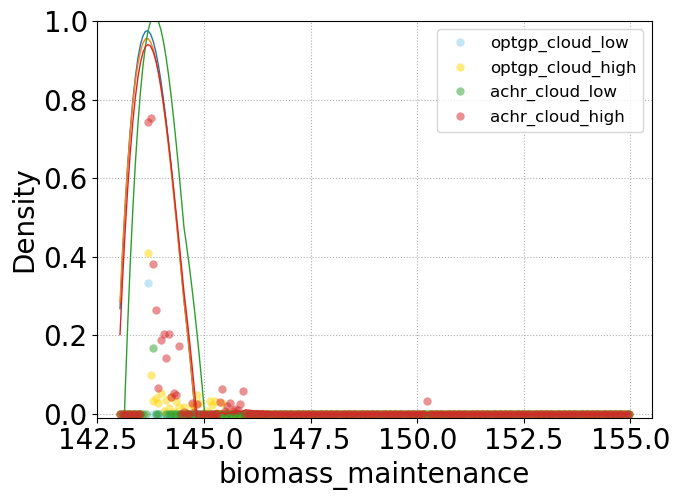

In [15]:
for i in range(len(clouds)):
    cloud = clouds[i]
    the_color = cloud_colors[i]
    bm = cloud['biomass_maintenance']
    print(numpy.min(bm), numpy.max(bm))
    hist, bin_edges = numpy.histogram(bm, bins=200, range=(143, 155), density=True)
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]

    # plot points
    matplotlib.pyplot.plot(x, hist, 'o', alpha=1/2, color=the_color, mec='none', label=cloud_names[i])

    # fit and plot line
    yhat = scipy.signal.savgol_filter(hist, 51, 3)
    matplotlib.pyplot.plot(x, yhat, '-', lw=1, alpha=1)

matplotlib.pyplot.xlabel('biomass_maintenance')
matplotlib.pyplot.ylabel('Density')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.legend(fontsize=12)
matplotlib.pyplot.ylim(-0.01, 1)
matplotlib.pyplot.xlim(142.5, 155.5)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# adding constrains

In [41]:
print(solution.fluxes['biomass_maintenance'])
top = solution.fluxes['biomass_maintenance']
bottom = solution.fluxes['biomass_maintenance']*0.90
print(bottom, top)

143.582775499576
129.2244979496184 143.582775499576


In [42]:
model.reactions.biomass_maintenance

Reaction identifier,biomass_maintenance
Name,Biomass maintenance reaction without replication precursors
Memory address,0x2af417090
Stoichiometry,0.50563 ala_L[c] + 0.35926 arg_L[c] + 0.27942 asn_L[c] + 0.35261 asp_L[c] + 20.7045 atp[c] + 0.020401 chsterol[c] + 0.011658 clpn_hs[c] + 0.039036 ctp[c] + 0.046571 cys_L[c] + 0.27519 g6p[c] +... 0.50563 L-Alanine + 0.35926 L-Arginine + 0.27942 L-Asparagine + 0.35261 L-Aspartate + 20.7045 Adenosine Triphosphate + 0.020401 Cholesterol + 0.011658 Cardiolipin + 0.039036...
GPR,
Lower bound,143.582775499576
Upper bound,1000.0


In [43]:
colb = model.problem.Constraint(model.reactions.biomass_maintenance.flux_expression, lb=100)
#coup = model.problem.Constraint(model.reactions.biomass_maintenance.flux_expression, ub=top)

model.add_cons_vars([colb, coup])

In [44]:
model.reactions.biomass_maintenance

Reaction identifier,biomass_maintenance
Name,Biomass maintenance reaction without replication precursors
Memory address,0x2af417090
Stoichiometry,0.50563 ala_L[c] + 0.35926 arg_L[c] + 0.27942 asn_L[c] + 0.35261 asp_L[c] + 20.7045 atp[c] + 0.020401 chsterol[c] + 0.011658 clpn_hs[c] + 0.039036 ctp[c] + 0.046571 cys_L[c] + 0.27519 g6p[c] +... 0.50563 L-Alanine + 0.35926 L-Arginine + 0.27942 L-Asparagine + 0.35261 L-Aspartate + 20.7045 Adenosine Triphosphate + 0.020401 Cholesterol + 0.011658 Cardiolipin + 0.039036...
GPR,
Lower bound,143.582775499576
Upper bound,1000.0


# re-sampling

In [45]:
%%time
cloud = cobra.sampling.sample(model, low_number_of_points)
cloud.head()

CplexSolverError: CPLEX Error  1210: Name not found.


# visualization after resampling

143.5827836969622 143.76368921810032
143.58278130776688 145.56514493419326
143.69359668587376 144.03830051978014
143.58277568396323 158.23530886941475


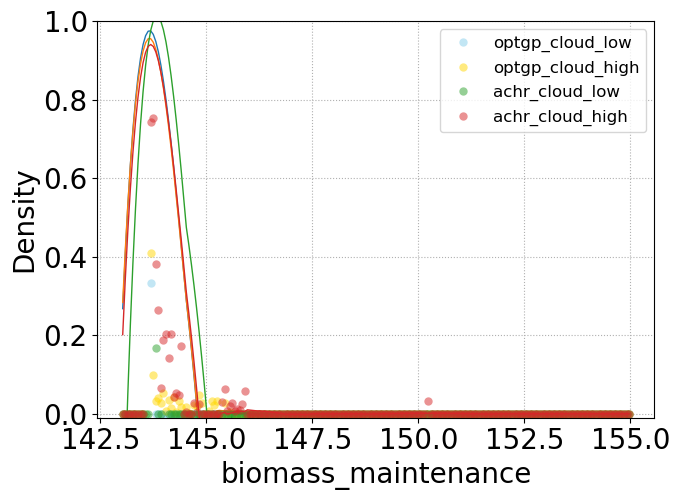

In [46]:
for i in range(len(clouds)):
    cloud = clouds[i]
    the_color = cloud_colors[i]
    bm = cloud['biomass_maintenance']
    print(numpy.min(bm), numpy.max(bm))
    hist, bin_edges = numpy.histogram(bm, bins=200, range=(143, 155), density=True)
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]

    # plot points
    matplotlib.pyplot.plot(x, hist, 'o', alpha=1/2, color=the_color, mec='none', label=cloud_names[i])

    # fit and plot line
    yhat = scipy.signal.savgol_filter(hist, 51, 3)
    matplotlib.pyplot.plot(x, yhat, '-', lw=1, alpha=1)

matplotlib.pyplot.xlabel('biomass_maintenance')
matplotlib.pyplot.ylabel('Density')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.legend(fontsize=12)
matplotlib.pyplot.ylim(-0.01, 1)
#matplotlib.pyplot.xlim(142.5, 155.5)

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()